## Variational Autoencoder and Generative Adversarial Network

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import random
from torch.utils.data import DataLoader


In [4]:
#defining global variables

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 3

# Loading the MNIST Dataset from torchvision
train_data = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

### Variational Autoencoder Derivation

Variational Autoencoder comprise of two modules, Encoder and Decoder modules. Each module uses the restricted boltzman machine mechanism to generate data representation in unsupervised learning scenario.

The encoder part performs the dimensionality reduction and Decoder then uses this representation to generate new data which is similar to input data. 

Weight matrix of decoder = transpose of weight matrix of encoder


let x be the observation and z be the hidden variable, we want to compute:

$
P(z|x) = \frac{P(x|z)P(z)}{P(x)} \\
\ \ \ \ \ \ \ \ \ \ \  = \frac{P(x, z)}{p(x)}
$

computing p(x) for high dimensional z is complex as it is an integral of all values $P(x|z)P(z)$, hence we use approximation approach using Variational Inference technique.


To approximate $P(z|x)$ we use another tractable distribution q (i.e gaussian, exponential, etc) and try to make q as close as distribution p.

We will use the idea of KL-divergence to make q similar to p as KL divergence provides information about similarity/dissimilarity between two distributions and is unsymmetric.

$
KL(q(z)||P(z|x)) = - \sum q(z) log \frac{P(z|x)}{q(z)} \\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = - \sum q(z) log \frac{ \frac{P(x, z)}{P(x)}}{q(z)} \\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  = - \sum q(z) \big[ log \frac{P(x, z)}{q(z)} - logP(x) \big ] \\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  = - \sum q(z) log \frac{P(x, z)}{q(z)} + log P(x) \sum_{z} q(z) \\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  = - \sum q(z) log \frac{P(x, z)}{q(z)} + log P(x) \\
as \sum_{z} q(z) = 1 \\
\\
\\
\\
=>\ \ logP(x) = KL(q(z)||P(z|x)) + \sum q(z) log\frac{P(x, z)}{q(z)}
$

logP(x) being constant we want to minizie the KL divergnece hence we can maximize $\sum q(z) log\frac{P(x, z)}{q(z)}$ term, This term is called variational lowerbound and is <= P(x)

So lower bound term can be written as:

$
\sum q(z) log \frac{P(x, z)}{q(z)} \\ 
= \sum q(z) log \frac{P(x|z)p(z)}{q(z)} \\
= \sum q(z) logP(x|z) + \sum q(z)  log \frac{P(z)}{q(z)} \\
$

In the above equation second term is negative KL divergence between q(z) and P(z) and the first term is the expectation of log P(x|z) with respect to q(z).

Hence our objective function becomes:

$
E_{q(z)} log P(x|z) - KL(q(z) || P(z))
$



Assuming q is a neural network that maps x to z and p is another neural network that maps z to x' hence this is the basis of the Autoencoder.


If we assume z has a Gaussian distribution then the autoencoder will make a distribution similar to another Gaussian distribution. The p neural network is deterministic as there will be same relationship between z and x' therefore $P(x|z)$ can be written as $P(x|x')$. This can be written as:
$P(x|x') = e^{-|x - x'|^{2}}  \\ $
taking log
$
\ \ => |x - x'|^{2} \\
$
So now our function becomes:

$
min |x - x'|^{2} + KL (q(z|x)||D())
$

where D() is the gaussian distribution.

Now, z has a normal distribution with parametrers $\mu \ \sigma$, Hence we train the network to learn these parameters and pass then we sample from this distribution and pass it to second network to generate x'. Thus our input data is mapped in hidden space which is a distribution and we now sample from this hidden space and feed it to the decoder.






In [165]:
# Variational Autoencoder Implementation
import tensorflow as tf
import tensorflow_datasets as tfd
from tensorflow.keras import layers as ly
from tensorflow.keras import models as ml
from tensorflow.keras import optimizers as opt
from tensorflow.keras import losses as ls
from tensorflow.keras import metrics as mt
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist


In [20]:
# getting the dataset
(df_train, df_test), df_info = tfd.load('mnist',
                                      split=['train', 'test'],
                                      shuffle_files=True,
                                      as_supervised=True,
                                      with_info=True)

In [21]:
#preprocessing the data
def normalize_data(tX, l):
    tX = tf.cast(tX, tf.float32) / 255.0
    tX = tf.reshape(tX, [784, 1])
    return tX, l

df_train = df_train.map(normalize_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
df_train = df_train.cache()
df_train = df_train.shuffle(df_info.splits['train'].num_examples)
df_train = df_train.batch(64)
df_train = df_train.prefetch(tf.data.experimental.AUTOTUNE)

df_test = df_test.map(normalize_data,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
df_test = df_test.cache()
df_test = df_test.batch(64)
df_test = df_test.prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
def layer_normalize(args):
    l1, l2 = args
    b = K.shape(l1)[0]
    d = K.int_shape(l1)[1]
    ep = K.random_normal(shape=(b, d))
    return l1 + K.exp(0.5 * l2) * ep

In [29]:
# Creating the Model VAE 

def create_model(num_hidden_units):
    
    #encoder
    encoder_ip = ly.Input(shape=(784,), name="encoder_ip")
    encoder_hid = ly.Dense(256, activation='relu')(encoder_ip)
    mean = ly.Dense(num_hidden_units, name='mean')(encoder_hid)
    var = ly.Dense(num_hidden_units, name='var')(encoder_hid)
    
    #normalizing to std dev
    z = ly.Lambda(layer_normalize, output_shape=(num_hidden_units,), name='z')([mean, var])
    
    encoder = ml.Model(encoder_ip, [mean, var, z], name='encoder')
    
    #Decoder
    decoder_ip = ly.Input(shape=(num_hidden_units,),name='sampling')
    decoder_hid = ly.Dense(256, activation='relu')(decoder_ip)
    decoder_op = ly.Dense(784,activation='sigmoid')(decoder_hid)
    
    decoder = ml.Model(decoder_ip, decoder_op,name='decoder')
    
    #VAE
    output = decoder(encoder(encoder_ip)[2])
    vae = ml.Model(encoder_ip, output, name='vae')
    
    reconstruction_loss = ls.binary_crossentropy(encoder_ip, output)
    reconstruction_loss*= 784
    kl_loss = 1 + var - K.square(mean) - K.exp(var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae, encoder, decoder

    
    



In [30]:
def display_images(decoder, hidden_units):
    num = 20
    digits= 28
    fig = np.zeros((digits*num, digits*num))
    axis_x = np.linspace(-3, 3, num)
    axis_y = np.linspace(-3, 3, num)[::-1]
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(hidden_units == 2):
                sample = np.array([[xi, yi]*int(hidden_units/2)])
                #sample = np.array([[xi, yi]*int(hidden_units/2)])
            else:
                sample = np.random.normal(0, 1, size=[batch_size, hidden_units])
            input_decoded = decoder.predict(sample)
            d = input_decoded[0].reshape(digits, digits)
            fig[i*digits : (i+1)*digits, j*digits : (j+1)*digits] = d
    plt.figure(figsize=(10, 10))
    i_range = digits//2
    j_range = (num-1) * digits + i_range + 1
    pixel_range = np.arange(i_range, j_range, digits)
    sample_range_x = np.round(axis_x, 1)
    sample_range_y = np.round(axis_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    #plt.imshow(fig, cmap='Blues_r')
    plt.imshow(fig)
    fig_name="VAE_"+str(hidden_units)+"_hidden_nodes"
    plt.savefig(fig_name)
    plt.show()

In [31]:
#creating the model with 16 hidden units
hidden_units=16
vae, encoder, decoder = create_model(hidden_units)
print(vae.summary())
vae.fit(df_train, validation_data=(df_test), epochs=50)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_ip (InputLayer)         [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 16), (None,  209184      encoder_ip[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          205840      encoder[0][2]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          200960      encoder_ip[0][0]                 
________________________________________________________________________________________________

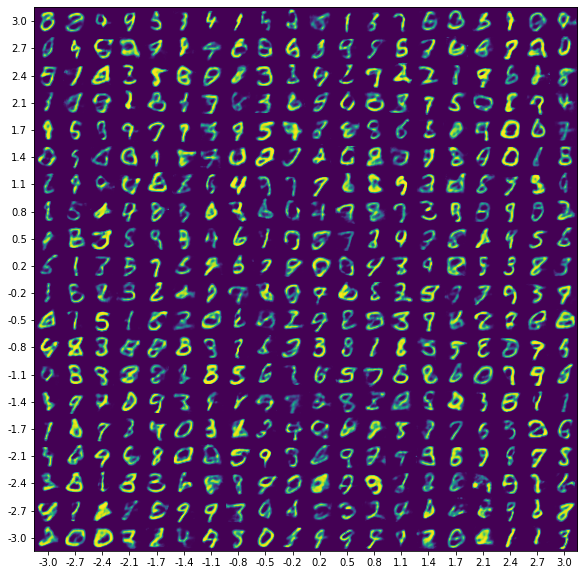

In [32]:
# displaying images 
display_images(decoder, hidden_units)

In [33]:
#creating the model with 8 hidden units
hidden_units=8
vae, encoder, decoder = create_model(hidden_units)
print(vae.summary())
vae.fit(df_train, validation_data=(df_test), epochs=50)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_ip (InputLayer)         [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 8), (None, 8 205072      encoder_ip[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          203792      encoder[0][2]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 256)          200960      encoder_ip[0][0]                 
________________________________________________________________________________________________

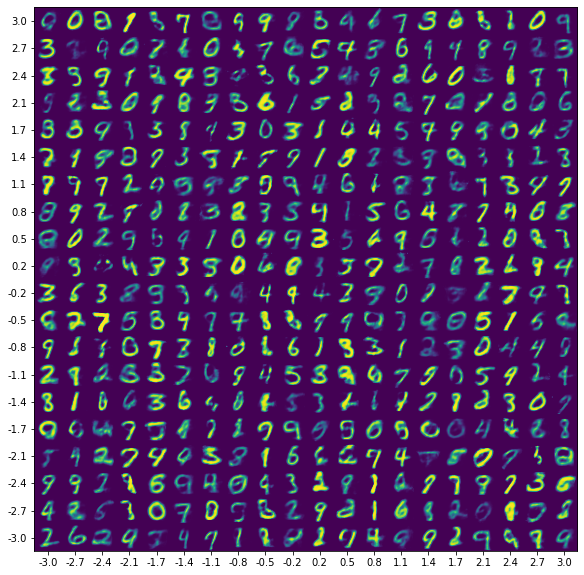

In [34]:
# displaying images 
display_images(decoder, hidden_units)

In [35]:
#creating the model with 2 hidden units
hidden_units=2
vae, encoder, decoder = create_model(hidden_units)
print(vae.summary())
vae.fit(df_train, validation_data=(df_test), epochs=50)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_ip (InputLayer)         [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      encoder_ip[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          200960      encoder_ip[0][0]                 
________________________________________________________________________________________________

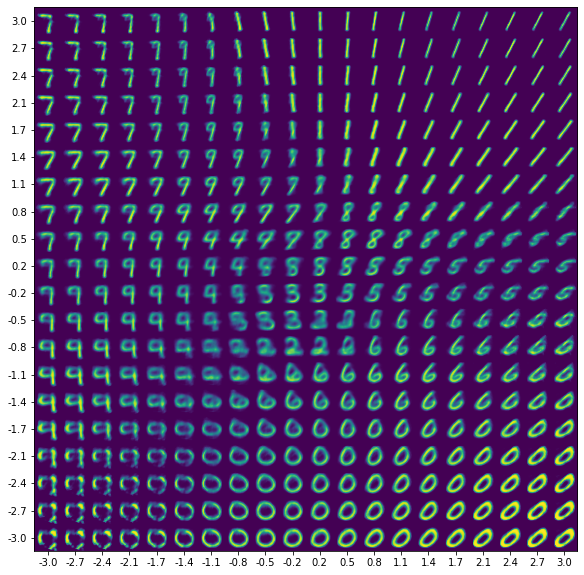

In [36]:
# displaying images 
display_images(decoder, hidden_units)

## Variational Autoencoder CNN

In [94]:
#declaring variables
batch_size=128
hidden_units=16
def layer_normalize(args):
    l1, l2 = args
    b = K.shape(l1)[0]
    d = K.int_shape(l1)[1]
    ep = K.random_normal(shape=(b, d))
    return l1 + K.exp(0.5 * l2) * ep

def sampling(args):
    l1, l2 = args
    b = K.shape
    ep = K.random_normal(shape=(batch_size, hidden_units), mean=0., stddev=1.0)
    return l1 + K.exp(0.5*l2) * ep
    

In [95]:
# getting the dataset
(df_train, df_test), df_info = tfd.load('mnist',
                                      split=['train', 'test'],
                                      shuffle_files=True,
                                      as_supervised=True,
                                      with_info=True)

In [96]:
#preprocessing the data
def normalize_data(tX, l):
    tX = tf.cast(tX, tf.float32) / 255.0
    return tX, l

df_train = df_train.map(normalize_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
df_train = df_train.cache()
df_train = df_train.shuffle(df_info.splits['train'].num_examples)
df_train = df_train.batch(batch_size)
df_train = df_train.prefetch(tf.data.experimental.AUTOTUNE)

df_test = df_test.map(normalize_data,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
df_test = df_test.cache()
df_test = df_test.batch(batch_size)
df_test = df_test.prefetch(tf.data.experimental.AUTOTUNE)

In [112]:
def create_cnn_model(hidden_dim=16):
    
    #encoder
    encoder_ips = ly.Input(shape=(28, 28, 1))
    encoder_ly1 = ly.Conv2D(64, 3, padding="same", activation='relu')(encoder_ips)
    encoder_ly2 = ly.Conv2D(128, 3, padding="same", activation='relu', strides=(2, 2))(encoder_ly1)
    shape_encoder = K.int_shape(encoder_ly2)
    encoder_ly3 = ly.Flatten()(encoder_ly2)
    encoder_ly4 = ly.Dense(32, activation='relu')(encoder_ly3)
    
    mean_ = ly.Dense(hidden_dim)(encoder_ly4)
    var_ = ly.Dense(hidden_dim)(encoder_ly4)
    
    z_ = ly.Lambda(layer_normalize, output_shape=(hidden_dim,))([mean_, var_])
    
    encoder_cnn = ml.Model(encoder_ips, [mean_, var_, z_], name='encoder_cnn')
 
    #Decoder
    decoder_ips = ly.Input(shape=(K.int_shape(z_)[1:]))
    encoder_ly1 = ly.Dense(np.prod(shape_encoder[1:]), activation='relu')(decoder_ips)
    encoder_ly2 = ly.Reshape(shape_encoder[1:])(encoder_ly1)
    encoder_ly3 = ly.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(encoder_ly2)
    encoder_ly4 = ly.Conv2D(1, 3, padding='same', activation='sigmoid')(encoder_ly3)
    
    decoder_cnn = ml.Model(decoder_ips, encoder_ly4, name='decoder_cnn')
    
    output_ = decoder_cnn(z_)
    input_ = K.flatten(encoder_ips)
    output_ = K.flatten(output_)
    
    #loss  
    reconstruction_loss = mt.binary_crossentropy(input_, output_)
    kl_loss = 0.5 * K.sum(K.square(mean_) + K.exp(var_) - var_ - 1, axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    vae_cnn = ml.Model(encoder_ips, output_)
    vae_cnn.add_loss(vae_loss)
    vae_cnn.compile(optimizer="adam")
    return vae_cnn, encoder_cnn, decoder_cnn


In [118]:
vae_cnn, encoder_cnn, decoder_cnn = create_cnn_model(hidden_units)
print(vae_cnn.summary())
#vae_cnn.compile(optimizer='adam')
vae_cnn.fit(df_train, validation_data=(df_test), epochs=50)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 28, 28, 64)   640         input_48[0][0]                   
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 14, 14, 128)  73856       conv2d_79[0][0]                  
__________________________________________________________________________________________________
flatten_27 (Flatten)            (None, 25088)        0           conv2d_80[0][0]                  
___________________________________________________________________________________________

In [119]:
def display_cnn_images(decoder, hidden_units):
    num = 20
    digits= 28
    fig = np.zeros((digits*num, digits*num))
    axis_x = np.linspace(-3, 3, num)
    axis_y = np.linspace(-3, 3, num)[::-1]
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(hidden_units == 2):
                sample = np.array([[xi, yi]*int(hidden_units/2)])
                #sample = np.array([[xi, yi]*int(hidden_units/2)])
            else:
                sample = np.random.normal(0, 1, size=[batch_size, hidden_units])
            input_decoded = decoder.predict(sample)
            d = input_decoded[0].reshape(digits, digits)
            fig[i*digits : (i+1)*digits, j*digits : (j+1)*digits] = d
    plt.figure(figsize=(10, 10))
    #plt.imshow(fig, cmap='Blues_r')
    plt.imshow(fig)
    fig_name="VAE_CNN"+str(hidden_units)+"_hidden_nodes"
    plt.savefig(fig_name)
    plt.show()

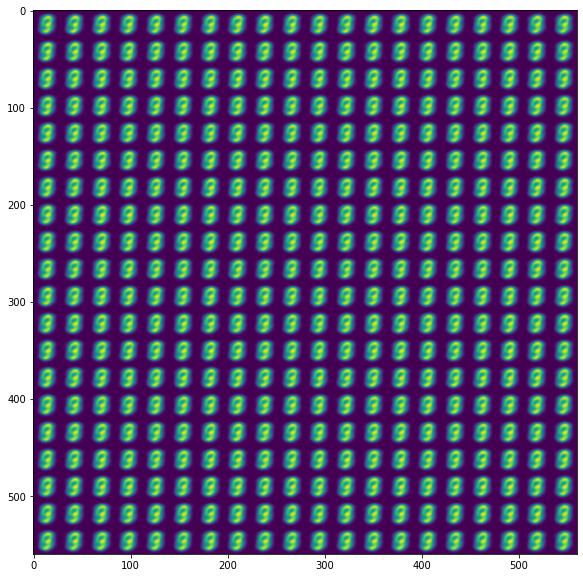

In [120]:
# displaying images 
display_cnn_images(decoder_cnn, hidden_units)

## Genrative Adversarial Network


GAN is a Generative Adversarial Network which has 2 models - Generator and Discriminator. Generator model generates the data similar to training data and Discriminator takes both the training data and generator data and try tell how much input is realistic.

#### Derivation

Using Binary Cross Entropy loss, the discriminator loss is defined as:


For real data, y=1


$
L(D(x), 1) = log(D(x)) 
$

For generated data coming from generator y=0

$
L(D(G(z), 0)) = log(1 - D(G(z)))
$


So loss function for discriminator becomes:


$
L(D) = max \big [ log(D(x)) + log(1 - D(G(z))) \big ]
$


Generator loss is defined as:


$
L(G) = min \big [ log(D(x)) + log(1 - D(G(z))) \big ]
$

Since generator try to create data very similar to original data hence loss should be minimized and discriminator tries to evaluate if data is real or fake hence the loss needs to be maximized.


So the loss function for GAN becomes:

$
L = min_{G} max_{D} \big [ log(D(x)) + log (1 - D(G(z))) \big ]
$


For implementation we will create two models generator and discriminator, when training the generator we will freeze the discriminator, then will input noised images to the generator and the output will be fed into discriminator. 

## GAN Implementation

In [228]:
# getting the dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX.reshape(-1, 784)
trainX = trainX.astype('float32')/255
testX = testX.reshape(-1, 784)
testX = testX.astype('float32')/255


In [229]:
# Creating Generator module
def create_generator(hidden_units):
    modelg = ml.Sequential([
        ly.Dense(128, input_dim=(hidden_units)),
        ly.LeakyReLU(alpha=0.2),
        ly.Dense(256),
        ly.LeakyReLU(alpha=0.2),
        ly.Dense(784, activation="sigmoid")
    ])
    modelg.compile(loss='binary_crossentropy', optimizer=opt.Adam(learning_rate=2e-4, beta_1=0.5), metrics=['accuracy'])
    return modelg

In [230]:
def create_discriminator(hidden_units):
    modeld = ml.Sequential([
        ly.Dense(256, input_dim=784),
        ly.LeakyReLU(alpha=0.2),
        ly.Dense(128),
        ly.LeakyReLU(alpha=0.2),
        ly.Dense(1, activation="sigmoid")
    ])
    modeld.compile(loss='binary_crossentropy', optimizer=opt.Adam(learning_rate=2e-4, beta_1=0.5), metrics=['accuracy'])
    return modeld

In [231]:
def create_gan(gen, disc, hidden_units):
    disc.trainable=False
    gan_input = ly.Input(shape=(hidden_units,))
    gen_output = gen(gan_input)
    gan_output = disc(gen_output)
    
    gan = ml.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=opt.Adam(learning_rate=2e-4, beta_1=0.5), metrics=['accuracy'])
    return gan
    

In [232]:
hidden_units = 100
lr = 1e-4
num_epochs = 200
batch_size = 128

generator = create_generator(hidden_units)

discriminator = create_discriminator(hidden_units)

gan = create_gan(generator, discriminator, hidden_units)

print(gan.summary())

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_33 (Sequential)   (None, 784)               247440    
_________________________________________________________________
sequential_34 (Sequential)   (None, 1)                 233985    
Total params: 481,425
Trainable params: 247,440
Non-trainable params: 233,985
_________________________________________________________________
None


In [233]:
#plotting the images
def plot_gen_images(ep, gen, hidden_units, num_examples=20, dim=(2, 10)):
    temp = np.random.normal(loc=0, scale=1, size=[num_examples, hidden_units])
    gen_images = gen.predict(temp)
    gen_images = gen_images.reshape(num_examples, 28, 28)
    
    plt.figure(figsize=(12, 2))
    for i in range(gen_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(gen_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    


Epoch : 0 


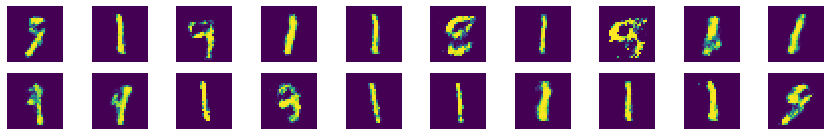

Epoch : 10 


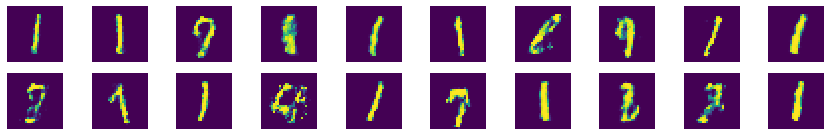

Epoch : 20 


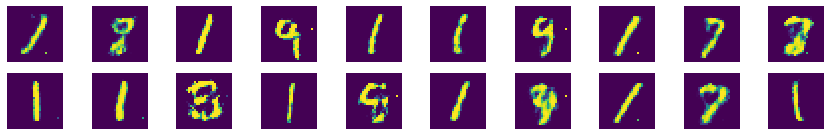

Epoch : 30 


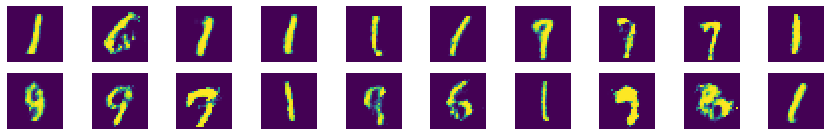

Epoch : 40 


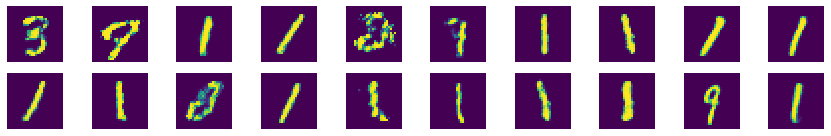

Epoch : 50 


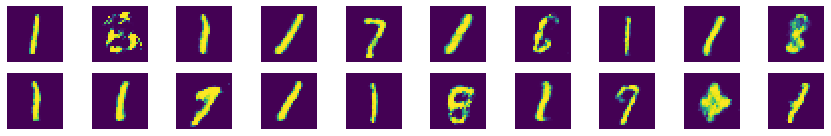

Epoch : 60 


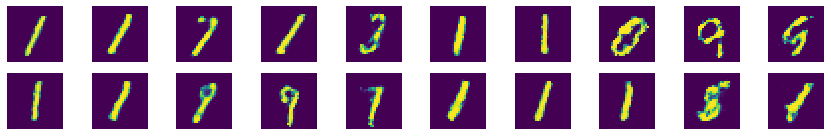

Epoch : 70 


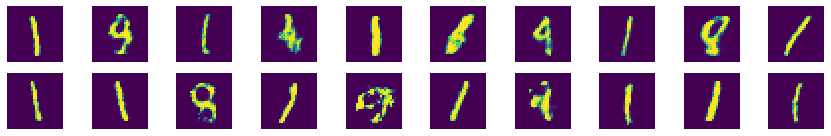

Epoch : 80 


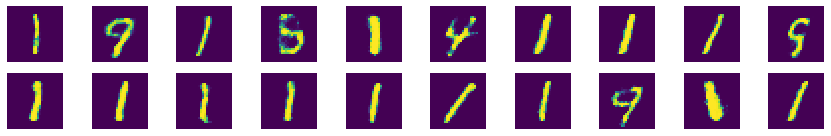

Epoch : 90 


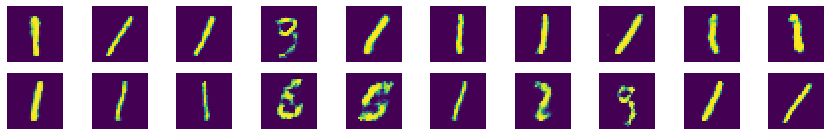

Epoch : 100 


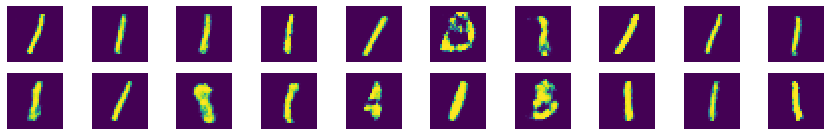

Epoch : 110 


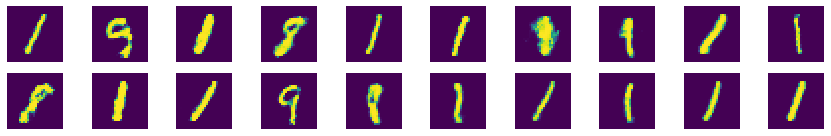

Epoch : 120 


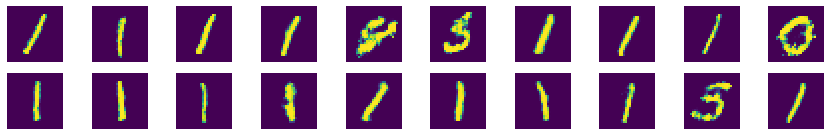

Epoch : 130 


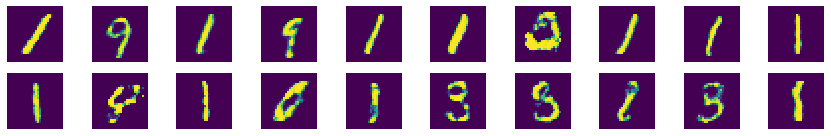

Epoch : 140 


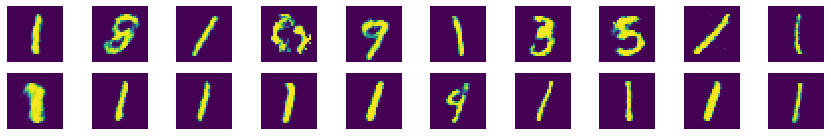

Epoch : 150 


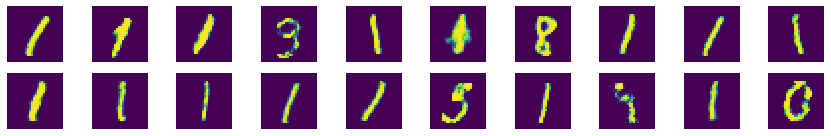

Epoch : 160 


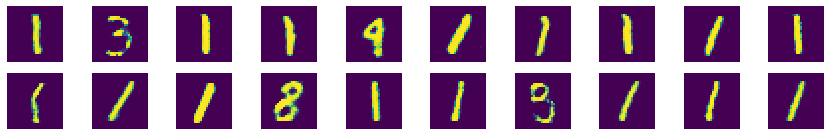

Epoch : 170 


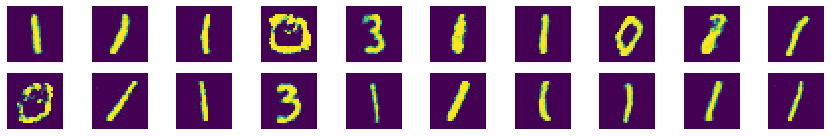

Epoch : 180 


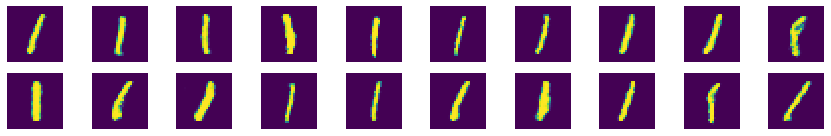

Epoch : 190 


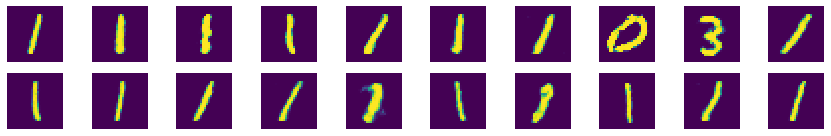

In [235]:
# Training the model
batch_count = int(trainX.shape[0] / batch_size)
for ep in range(num_epochs):
    for _ in range(batch_count):
        
        #fetch random images
        rand_num = np.random.randint(0, trainX.shape[0], size=batch_size)
        img1 = trainX[rand_num]
        
        #generate random noise as input
        rand_noise = np.random.normal(0, 1, size=(batch_size, hidden_units))
        
        #generate fake MNIST images
        gen_img = generator.predict(rand_noise)
        
        #batches of real and fake data
        x = np.concatenate((img1, gen_img))
        
        # labels for generated and real data
        y = np.zeros(2*batch_size)
        y[:batch_size] = 0.8
        
        # train discriminator before training the gan
        discriminator.trainable=True
        d_loss = discriminator.train_on_batch(x, y)
        
        # noised data input of generator as real data
        rand_noise2 = np.random.normal(0, 1, size=(batch_size, hidden_units))
        y2 = np.ones(batch_size)
        
        # train the gan with discriminator weights fixed
        discriminator.trainable=False
        g_loss = gan.train_on_batch(rand_noise2, y2)
    if(ep%10 == 0):
        print("Epoch : %d " %ep)
        plot_gen_images(ep, generator, hidden_units)
        